<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/dacon_ipynb_1111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. EDA  : 데이터 사전 탐색
#    0) Dataframe 살펴보기
#    1) 차트그리기
# 2. 결측치/이상치 --> 처리
# 3. 피쳐 전처리/가공
# 4. 학습/평가 : f1, auc
# 5. 검증(GridSearchCV, confusion_matrix)

import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy            import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score, f1_score, roc_auc_score,\
                             precision_score,recall_score, roc_curve, classification_report,precision_recall_curve
from sklearn                 import preprocessing
from sklearn.preprocessing   import StandardScaler,RobustScaler,MinMaxScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
import warnings
warnings.filterwarnings(action="ignore")
barline = "\n============================================"
e = "\n"

# Dataframe 확인 ---------------------------------------
def MyCheckDataframe(df, target="target") :
    print("Check Dataframe ----------------------------")
    print("Shape :", e, df.shape)
    print("Info  :", e, df.info())
    print("Head  :", e, df.head())
    print("Count :", e, df[target].value_counts())

    y = df[target]
    X = df.drop(target, axis=1)
    print("Target Shape :", e, X.shape, y.shape, barline)
    return X, y
# X,y = CHECK_DATAFRAME(df, target="")


# -------------------------------------
# 4-2. IQR : 25%~75% 범위 값
# -------------------------------------
def MyCheckOutlier(df=None, column=None, print=None):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    for k, v in df.items():
        Q1 = v.quantile(0.25)
        Q3 = v.quantile(0.75)
        IQR = Q3 - Q1
        IQR_weight = IQR * 1.5
        minimum = Q1 - IQR_weight
        maximum = Q3 + IQR_weight
        outlier_idx = v[(v < minimum) | (v> maximum)].index

        if print == True:
            perc = np.shape(outlier_idx)[0] * 100.0 / np.shape(df)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    print(barline)
    return outlier_idx
    # Q1  = np.percentile(df[column].values, 25)
    # Q3  = np.percentile(df[column].values, 75)
    # IQR = Q3 - Q1
    # IQR_weight  = IQR * 1.5
    # minimum     = Q1 - IQR_weight
    # maximum     = Q3 + IQR_weight
    # outlier_idx = df[column][  (df[column] < minimum) | (df[column] > maximum)  ].index

# outlier_idx = CHECK_OUTLIER(df=df, column=col)
# print(col, oulier_idx)
# df.drop(outlier_idx, axis=0, inplace=True)
    #---------------------------------------------
    # numeric_columns = df.dtypes[df.dtypes != 'object'].index
    # for i, col in enumerate(numeric_columns) :
    #     oulier_idx = CHECK_OUTLIER(df=df, column=col)
    #     print(col , oulier_idx)
    #     #df.drop(outlier_idx, axis=0, inplace=True)


def MyCheckZeros(X):
    print("Check Zeros --------------------------------")
    for col in X.columns:
        gcnt = X[col][X[col] == 0].count()
        print(col, ":", gcnt, "(", np.round(gcnt / X.shape[0] * 100, 2), ")")
    print(barline)

def MyCheckNull(X):
    print("Check Null ---------------------------------")
    # print(df.isnull().sum())
    for col in X.columns:
        gcnt = X[col][X[col] == np.nan].count()
        print(col, ":", gcnt, "(", np.round(gcnt / X.shape[0] * 100, 2), ")")
    print(barline)

def MyScores(y_test, pred, proba, str=None) :
    print("Scores : {} ---------" .format(str))
    acc       = accuracy_score(y_test, pred)
    f1        = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall    = recall_score(y_test, pred)
    auc       = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
    print("정확도{:.4f}  F1 {:.4f}=(정밀도{:.4f} 재현률{:.4f}) auc {:.4f}" .format(acc, f1, precision, recall, auc))
    cf_matrix = confusion_matrix(y_test, pred)
    print("Confusion Matrix", e, cf_matrix, barline)


def MySplitFitPredict(model, X, y, str=None, rate=0.2, prc=False, roc=False) :
    X_train ,X_test , y_train, y_test = train_test_split(X, y, test_size=rate, random_state=121)
    model.fit(X_train, y_train)
    pred  = model.predict(X_test)
    proba = model.predict_proba(X_test)

    MyScores(y_test, pred, proba, str)

    if prc == True:
        MyChartPrcRclCurve(y_test, proba)
    if roc == True:
        MyChartRocCurve(y_test, proba)
    return proba # X_train, X_test, y_train, y_test, proba # , pred, proba
# rf_model = RandomForestClassifier()
# SPLIT_FIT_PREDICT(rf_model, X, y, str="최초점수", 0.5)
# SPLIT_FIT_PREDICT(rf_model, X, y)


def MyChartHeatmap(df, targetClass=None, topn=0):
    plt.figure(figsize=(10,6))
    if   topn > 0 :
        idx = df.corr().nlargest(topn, targetClass).index
        print("Correlation: Top", topn, e, idx, barline)
        sns.heatmap(df[idx].corr(), annot=True, fmt=".2g", cmap="Blues")
    elif topn < 0 :
        idx = df.corr().nsmallest(-1 * topn, targetClass).index
        print("Correlation: Bottom", -topn, e, idx, barline)
        sns.heatmap(df[idx].corr(), annot=True, fmt=".2g", cmap="Blues")
        # cols = ['V12', 'V14', 'V10', 'V17', 'V3','Class']
        # sns.heatmap(df[cols].corr(), annot=True, fmt=".2g", cmap="Blues")
    else :
        sns.heatmap(df.corr(), annot=True, fmt=".2g", cmap="Blues")
    plt.show()
# CHART_HEATMAP(df, 5)
# CHART_HEATMAP(df, -5)
# CHART_HEATMAP(df)

def MyCrossValidate(model, X, y, cv=5) :
    print("Cross Validation ---------------------------")
    my_score   = {"acc":"accuracy", "f1":"f1"}
    score_list = cross_validate(model, X, y, scoring=my_score, cv=5, verbose=0)
    score_df   = pd.DataFrame(score_list)
    print("cross_validation 평균 정확도 : " , score_df["test_acc"].mean())
    print("cross_validation 평균 f1    : "    , score_df["test_f1"].mean())
    print(barline)
# CROSS_VALIDATION(model, X, y)

my_hyper_param = {  "n_estimators"     :[100, 300],
                    "max_depth"        :[4, 5, 6],
                    "min_samples_leaf" :[2, 3, 4],
                    "random_state"     :[121,]    }

def MyGridSearchCV(my_hyper_param, model, X, y) :
    print("GridSerchCV --------------------------------")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)
    my_score  = {"acc": "accuracy", "f1": "f1"}
    gcv_model = GridSearchCV(model, param_grid=my_hyper_param, scoring=my_score, refit="f1", cv=5, verbose=0)
    gcv_model.fit(X_train, y_train)

    # print("best_estimator:", gcv_model.best_estimator_)
    print("best_params :", gcv_model.best_params_)
    print("best_score  :", gcv_model.best_score_)
    print("GridSearchCV 평균 정확도 : ", gcv_model.cv_results_["mean_test_acc"].mean())  #mean_test_(본인의score키값)
    print("GridSearchCV 평균 F1    : ", gcv_model.cv_results_["mean_test_f1"].mean())
    print(barline)
# my_hyper_param = {  "n_estimators"     :[100]}
# GRIDSEARCHCV(my_hyper_param, model, X_train, y_train)


def MyGroupFillNa(bycol, cols, tcol):
    dict = df.groupby(by=[bycol])[cols].mean().astype(np.int32).to_dict()
    fill_mean_func = lambda gname: gname.fillna(dict[bycol][gname[tcol]])
    df   = df.groupby(bycol).apply(fill_mean_func)
    return df
# df["Name2"] = df["Name"].str.extract("([A-Za-z]+)\.")
# dict = df.groupby(by=["Name2"])[["Name2","Age"]].mean().astype(np.int32).to_dict()
# fill_mean_func = lambda gname: gname.fillna(dict['Age'][gname.name])
# df = df.groupby('Name2').apply(fill_mean_func)
# df = GROUP_FILLNA_MEAN("Name2",["Name2","Age"],"name"

def MyReplace(target_df, a, b) :
    target_df = target_df.replace(a, b)
    return target_df
#DF_REPLACE(X[["Insulin", "BMI"]], 0, X[["Insulin", "BMI"]].median())
#X["BMI"] = DF_REPLACE(X["BMI"], 0, 99)

# def MyScaler(scaler_model):
#     scaler   = scaler_model
#     X_scaler = scaler.fit_transform(X)
#     return X_scaler
# # X_scaler = SCALER(StandardScaler())
def MyScaler(X):
    scaler   = StandardScaler()
    X_scaler = scaler.fit_transform(X)
    return X_scaler
# X_scaler = SCALER(StandardScaler())

def MyChartPrcRclCurve(y_test, proba):
    precision, recall, th = precision_recall_curve(y_test, proba[:, 1])
    print(len(precision), len(recall), len(th), barline)
    plt.plot(th, precision[:len(th)], label="precision")
    plt.plot(th, recall[:len(th)],    label="recall")
    plt.xlabel("threadshold"); plt.ylabel("precision & recall value")
    plt.legend()  # plt.legend(["precision","recall"])
    plt.grid()
    plt.show()

def MyChartRocCurve(y_test, proba):
    fpr, tpr, th = roc_curve(y_test, proba[:, 1])
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], label='th:0.5')
    # plt.title(auc)
    plt.xlabel("FPR"); plt.ylabel("TPR(recall)")
    plt.grid()
    plt.show()


# ------------------------------------------------
# precision_recall_curve : 임계치 튜닝을 통한 점수 보정
#-------------------------------------------------
ths = [.4, .43, .45, .47, .49, .51, .53]
def MyPrcRclTune(model, X, y, ths=ths):
    for th in ths:
        print("N : P =", th, ":", 1 - th)
        prob = MySplitFitPredict(model, X, y, prc=True)
        print(prob[4])
        bn = Binarizer(threshold=ths)
        fit_trans = bn.fit_transform(prob[:, 1].reshape(-1, 1))  # 세로로 reshape

        auc = roc_auc_score(y_test, prob[:, 1].reshape(-1, 1))
        print(auc)

# ------------------------------------------------
# boxplot : Boston-house-prices 사용
# distplot: Boston-house-prices 사용
#-------------------------------------------------
def MyPlots(data, plot, ncols=7, nrows=2):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 10))
    index = 0
    axs = axs.flatten()     # 1차원으로 바꿔주기
    for k, v in data.items():
        if   plot == 'distplot':
            sns.distplot(v, ax=axs[index])
        elif plot == 'boxplot':
            sns.boxplot(y=k, data=data, ax=axs[index])
        index += 1
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [2]:
# df_feature = pd.read_csv("train_features.csv")
# df_labels  = pd.read_csv("train_labels.csv")

In [3]:
# df_feature.info()
# df_labels.info()

In [4]:
# df = pd.merge(df_feature, df_labels, on='id', how='outer')
# df.head(100)

In [5]:
# target_col = ["label", "label_desc"]
# X_train = df.drop(target_col, axis=1)
# y_train = df["label"]

# X_train.info()
# y_train.head()

## 1. 데이터 불러오기

In [6]:
# train       = pd.read_csv('train_features.csv')
# train_label = pd.read_csv('train_labels.csv')
# test        = pd.read_csv('test_features.csv')
# submission  = pd.read_csv('sample_submission.csv')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train       = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_features.csv')
train_label = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_labels.csv')
test        = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_features.csv')
submission  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')

## 2. 데이터 탐색

## 3. 데이터 전처리

In [9]:
# id reset_index

#### 내꺼

In [10]:
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']
X_train = train[features].groupby('id').agg(['max', 'min', 'median', 'std'])   #, 'median', 'std'])
X_test  = test[features].groupby('id').agg(['max', 'min', 'median', 'std'])    #, 'median', 'std'])

In [11]:
X_train.shape, X_test.shape
# X_train.head()

((3125, 24), (782, 24))

In [12]:
X_train.describe()

acc_x               ...         gy_z             
               max          min  ...       median          std
count  3125.000000  3125.000000  ...  3125.000000  3125.000000
mean      0.589042    -1.593947  ...     0.098485    50.507994
std       0.998574     1.254887  ...    10.418103    49.008674
min      -1.010246    -8.838427  ...  -134.505407     0.030056
25%      -0.076559    -1.829921  ...    -2.394793    22.234081
50%       0.510224    -1.456669  ...     0.018462    39.532874
75%       1.069205    -1.104682  ...     2.299125    60.663193
max       8.426799     0.873007  ...    98.103222   462.832350

[8 rows x 24 columns]

In [13]:
X_test.head()

acc_x                      ...        gy_z                      
           max       min    median  ...         min     median        std
id                                  ...                                  
3125 -0.275446 -1.564000 -1.064222  ...  -35.446915  -1.607847  12.251648
3126  0.627571 -1.929033 -0.677411  ... -147.597574 -10.833508  61.604867
3127  2.972063 -0.792916  0.497370  ... -154.477074  -3.087735  23.041463
3128  0.337281 -1.045889 -0.880541  ... -117.297766  -0.404583  37.967372
3129  0.015642 -2.153047 -0.703842  ... -125.598600   1.866352  43.353007

[5 rows x 24 columns]

In [14]:
# y_train = train_label['label']

In [15]:
#컬럼명 변경
p_columns = [agg + '_' + column for agg, column in X_train.columns]
X_train.columns = p_columns
X_test.columns = p_columns

In [16]:
X_train.head()

,acc_x_max,acc_x_min,acc_x_median,acc_x_std,acc_y_max,acc_y_min,acc_y_median,acc_y_std,acc_z_max,acc_z_min,acc_z_median,acc_z_std,gy_x_max,gy_x_min,gy_x_median,gy_x_std,gy_y_max,gy_y_min,gy_y_median,gy_y_std,gy_z_max,gy_z_min,gy_z_median,gy_z_std
id,,,,,,,,,,,,,,,,,,,,,,,,
0,1.344268,0.591940,0.956149,0.191479,0.176871,-0.624113,-0.240638,0.177131,-0.054876,-0.786336,-0.346749,0.135131,31.644123,-46.254836,-1.273569,13.284216,69.847244,-85.887677,-2.362230,24.300479,55.953827,-79.930029,1.913286,25.275185
1,1.234020,-2.156208,-0.805767,0.495528,0.700065,-1.295598,-0.228905,0.336415,0.888661,-1.019531,-0.034583,0.499395,286.624363,-325.328531,3.810650,79.244561,389.608060,-315.096003,8.043707,96.005289,340.170199,-270.980823,-0.655819,75.545343
2,1.219836,-1.142847,0.140667,0.711972,0.650645,-0.690990,-0.062598,0.147127,1.332992,0.073846,0.634781,0.248807,73.525082,-164.779067,-8.112557,25.422926,297.320834,-249.953944,19.306132,118.956646,55.642836,-44.192071,3.568888,13.920337
3,-0.622250,-1.417751,-0.880343,0.130899,0.283721,-0.540827,-0.054577,0.194008,0.598814,-0.257124,0.231537,0.205882,192.765368,-69.419166,8.229938,42.928860,159.083788,-82.537304,1.783260,36.953466,56.456908,-85.600536,-3.853078,23.647153
4,0.599720,-2.429109,-0.941146,0.495170,1.724782,-2.055076,-0.168467,0.570305,2.678034,-1.250483,0.293556,0.389646,613.972600,-769.076518,-1.292194,108.258866,284.952954,-243.909948,0.977772,60.514531,221.015193,-270.581913,-0.750283,46.148326


In [17]:
X_train.shape

(3125, 24)

In [18]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [19]:
def plot_acc_id(df, id_num):
    return df.query('id == @id_num')[['time', 'acc_x', 'acc_y', 'acc_z']].plot(x = 'time')

def plot_gy_id(df, id_num):
    return df.query('id == @id_num')[['time', 'gy_x', 'gy_y', 'gy_z']].plot(x = 'time')

(-100.0, 100.0)

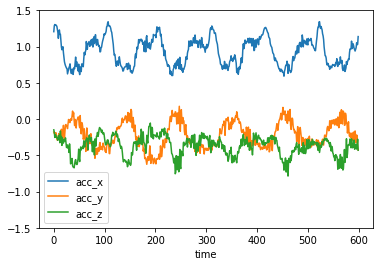

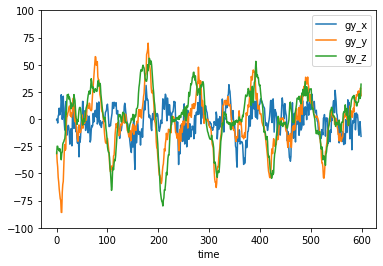

In [20]:
plot_acc_id(train, 0)
plt.ylim((-1.5, 1.5))
plot_gy_id(train, 0)
plt.ylim((-100, 100))

(-200.0, 200.0)

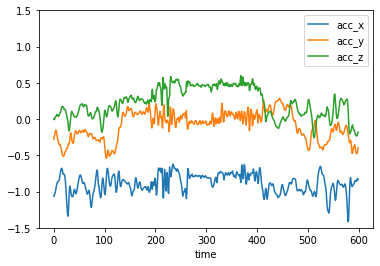

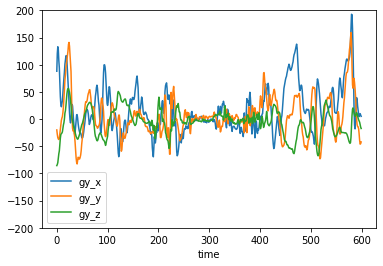

In [21]:
plot_acc_id(train, 3)
plt.ylim((-1.5, 1.5))
plot_gy_id(train, 3)
plt.ylim((-200, 200))

쉴 때는 움직임이 dynamic하지 않음
운동과 쉴 때 측정된 값 높낮이가 다를 것이며, 운동 끼리도 높낮이가 다를 것으로 추정

## 4. 모델링

In [22]:
y_train = train_label['label']

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1, random_state=0, min_samples_leaf=30)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
# y_pred = model.predict_proba(X_test)
# y_pred

In [25]:
# MyPlots(X_train, "boxplot", 8, 3)

In [26]:
scaler   = RobustScaler()

X_scaler = scaler.fit_transform(X_train)

In [27]:
# MySplitFitPredict(model, X_scaler, y)
# y_pred = model.predict_proba(X_scaler)
# y_pred

In [28]:
# scaler   = RobustScaler()

# num_sample   = X.shape[0] # 3 (샘플 데이터)
# num_sequence = X.shape[1] # 4 (시계열 데이터)
# num_feature  = X.shape[2] # 2 (Feature)

# # 시계열을 선회하면서 피팅합니다
# for ss in range(num_sequence):
#     scaler.fit_transform(X[:, ss, :])
# # 스케일링(변환)합니다.
# results = []
# for ss in range(num_sequence):
#     results.append(scaler.transform(X[:, ss, :]).reshape(num_sample, 1, num_feature))
# X_scaled = np.concatenate(results, axis=1)


# # X_scaler = scaler.fit_transform(X)

# X_scaled.shape

In [29]:
my_hyper_param = {  "n_estimators"     :[100, 300],
                    "max_depth"        :[4, 5, 6],
                    "min_samples_leaf" :[2, 3, 4],
                    "random_state"     :[121,]    }

def MyGridSearchCV(my_hyper_param, model, X, y) :
    print("GridSerchCV --------------------------------")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)
    my_score  = {"acc": "accuracy", "f1": "f1"}
    gcv_model = GridSearchCV(model, param_grid=my_hyper_param, scoring=my_score, refit="f1", cv=5, verbose=0)
    gcv_model.fit(X_train, y_train)

    # print("best_estimator:", gcv_model.best_estimator_)
    print("best_params :", gcv_model.best_params_)
    print("best_score  :", gcv_model.best_score_)
    print("GridSearchCV 평균 정확도 : ", gcv_model.cv_results_["mean_test_acc"].mean())  #mean_test_(본인의score키값)
    print("GridSearchCV 평균 F1    : ", gcv_model.cv_results_["mean_test_f1"].mean())
    print(barline)

MyGridSearchCV(my_hyper_param, model, X_scaler, y_train)

GridSerchCV --------------------------------


ValueError: ignored

# Dobby

In [ ]:
# import pandas as pd
# import numpy as np
# import random
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# from glob import glob

# x_train = []

# for uid in tqdm(train['id'].unique()):
#     temp = np.array(train[train['id'] == uid].iloc[:,2:], np.float32).T
#     x_train.append(temp)

# x_train = np.array(x_train, np.float32)
# x_train = x_train[:,:,:,np.newaxis]

# x_test = []

# for uid in tqdm(test['id'].unique()):
#     temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
#     x_test.append(temp)

# x_test = np.array(x_test, np.float32)
# x_test = x_test[:,:,:,np.newaxis]

In [ ]:
x_train.shape

## DACON

In [30]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping

import pandas as pd
import numpy
import os
import tensorflow as tf

In [31]:
X = tf.reshape(np.array(train.iloc[:,2:]),[-1, 600, 6])

y = tf.keras.utils.to_categorical(train_label['label']) 


y_train = tf.keras.utils.to_categorical(y_train) 

X.shape; y.shape

(3125, 61)

LSTM: (3125, 600, 6) -> 600개씩 feature 6개를 잘라

Dense: (3125*600, 6)  -> 6개 feature: 3125개

X = (3125, 600, 6)  => reshape
Dense (X) 

### 모델 학습 및 예측

In [32]:
model = Sequential()
model.add(LSTM(32, input_shape=(600,6)))
# model.add(Dense(30,  input_dim=12, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(12, kernel_initializer='normal', activation='relu'))
Dropout(0.25)
model.add(Dense(8, activation='relu'))
model.add(Dense(61, activation='softmax'))

model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 저장 폴더 만들기
# MODEL_DIR = 'content/MyDrive/Colab Notebooks/dacon/model/'
# if not os.path.exists(MODEL_DIR):
#    os.mkdir(MODEL_DIR)

modelpath="content/MyDrive/Colab Notebooks/dacon/model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100)

# model.fit(X, y, validation_split=0.2, epochs=3500, batch_size=500, verbose=0, callbacks=[early_stopping_callback,checkpointer])
model.fit(X,y, epochs=3000, batch_size=128, validation_split=0.2, verbose=0, callbacks=[early_stopping_callback,checkpointer])
# model.fit(X,y, epochs=30, batch_size=128, validation_split=0.2)   # leaderboard


Epoch 00001: val_loss improved from inf to 4.00529, saving model to content/MyDrive/Colab Notebooks/dacon/model/01-4.0053.hdf5

Epoch 00002: val_loss improved from 4.00529 to 3.72460, saving model to content/MyDrive/Colab Notebooks/dacon/model/02-3.7246.hdf5

Epoch 00003: val_loss improved from 3.72460 to 3.08801, saving model to content/MyDrive/Colab Notebooks/dacon/model/03-3.0880.hdf5

Epoch 00004: val_loss improved from 3.08801 to 2.84106, saving model to content/MyDrive/Colab Notebooks/dacon/model/04-2.8411.hdf5

Epoch 00005: val_loss improved from 2.84106 to 2.77135, saving model to content/MyDrive/Colab Notebooks/dacon/model/05-2.7714.hdf5

Epoch 00006: val_loss improved from 2.77135 to 2.73702, saving model to content/MyDrive/Colab Notebooks/dacon/model/06-2.7370.hdf5

Epoch 00007: val_loss improved from 2.73702 to 2.71989, saving model to content/MyDrive/Colab Notebooks/dacon/model/07-2.7199.hdf5

Epoch 00008: val_loss improved from 2.71989 to 2.70826, saving model to content

In [33]:
X_test.shape

(782, 24)

In [34]:
model = Sequential()
model.add(LSTM(32, input_shape=(600,6)))
# model.add(Dense(30,  input_dim=24, activation='relu'))
model.add(Dense(20, activation='relu'))
Dropout(0.25)
model.add(Dense(12, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(61, activation='softmax'))

model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

# 모델 업데이트 및 저장
modelpath="content/MyDrive/Colab Notebooks/dacon/model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100)

model.fit(X_scaled,y, epochs=3000, batch_size=128, validation_split=0.2, verbose=0, callbacks=[early_stopping_callback,checkpointer])

NameError: ignored

In [ ]:
X_test  = test[features].groupby('id').agg(['max', 'min', 'median', 'std'])    #, 'median', 'std'])

In [ ]:
X_test.shape

In [ ]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
# test_X.shape

prediction=model.predict(test_X)
# prediction=model.predict(X_test)

prediction.shape

In [ ]:
submission.iloc[:,1:]=prediction
submission.to_csv('baseline_submission5.csv', index=False)